In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [2]:
import os
import numpy as np
import h5py
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dropout, Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import MeanIoU, SparseCategoricalAccuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tqdm import tqdm

DATA_PATH = './IMAGE'
SIZE_X = 224  
SIZE_Y = 224  
BATCH_SIZE = 9
EPOCHS = 100
VAL_SPLIT = 0.2

def standardize(x):
    x = np.array(x, dtype='float32')
    x -= np.min(x)
    x /= np.percentile(x, 98)
    x = np.clip(x, 0, 1)
    return x

def preprocess_image_mask(img, mask):
    img = cv2.resize(img, (SIZE_X, SIZE_Y))
    img = standardize(img)
    img = np.expand_dims(img, axis=-1)  
    
    mask = cv2.resize(mask, (SIZE_X, SIZE_Y), interpolation=cv2.INTER_NEAREST)
    mask = np.clip(mask, 0, 1).astype(np.uint8)  
    return img, mask

def load_dataset(data_path):
    images = []
    masks = []
    labels = []

    for file_name in tqdm(os.listdir(data_path)):
        if file_name.endswith('.mat'):
            with h5py.File(os.path.join(data_path, file_name), 'r') as f:
                cjdata = f['cjdata']
                img = np.array(cjdata['image']).astype('float32')
                mask = np.array(cjdata['tumorMask']).astype('float32')
                
                img, mask = preprocess_image_mask(img, mask)
                
                images.append(img)
                masks.append(mask)
                labels.append(int(np.array(cjdata['label']).flatten()[0]) - 1)

    return np.array(images), np.array(masks), np.array(labels)


In [3]:

print("Loading data...")
images, masks, labels = load_dataset(DATA_PATH)



Loading data...


100%|█████████████████████████████████████████████████████████████████████████████| 1155/1155 [00:07<00:00, 156.00it/s]


In [4]:
X_train, X_test, y_train_mask, y_test_mask, y_train_labels, y_test_labels = train_test_split(
    images, masks, labels,
    test_size=VAL_SPLIT, 
    random_state=1,
    stratify=labels
)


In [5]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def combined_model(IMG_HEIGHT=224, IMG_WIDTH=224, IMG_CHANNELS=1, num_classes=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    # Encoder (Deeper U-Net)
    c1 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(1e-4))(inputs)
    c1 = Dropout(0.3)(c1)
    c1 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(1e-4))(c1)
    p1 = MaxPooling2D((2,2))(c1)
    
    c2 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(1e-4))(p1)
    c2 = Dropout(0.3)(c2)
    c2 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(1e-4))(c2)
    p2 = MaxPooling2D((2,2))(c2)
    
    c3 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(1e-4))(p2)
    c3 = Dropout(0.4)(c3)
    c3 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(1e-4))(c3)
    p3 = MaxPooling2D((2,2))(c3)
    
    c4 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(1e-4))(p3)
    c4 = Dropout(0.4)(c4)
    c4 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(1e-4))(c4)
    p4 = MaxPooling2D((2,2))(c4)
    
    c5 = Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(1e-4))(p4)
    c5 = Dropout(0.5)(c5)
    c5 = Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(1e-4))(c5)
    
    # Decoder
    u6 = Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(u6)
    c6 = Dropout(0.4)(c6)
    c6 = Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(c6)
    
    u7 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(u7)
    c7 = Dropout(0.4)(c7)
    c7 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(c7)
    
    u8 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(u8)
    c8 = Dropout(0.3)(c8)
    c8 = Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(c8)
    
    u9 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(u9)
    c9 = Dropout(0.3)(c9)
    c9 = Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(c9)
    
    segmentation_output = Conv2D(1, (1,1), activation='sigmoid', name='segmentation_output')(c9)
    
    x = GlobalAveragePooling2D()(c5)
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.5)(x)
    classification_output = Dense(num_classes, activation='softmax', name='classification_output')(x)
    
    model = Model(inputs=[inputs], outputs=[segmentation_output, classification_output])
    return model


In [6]:

def jacard_coef(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true + y_pred) - intersection
    return (intersection + 1e-7) / (union + 1e-7)


In [7]:

model = combined_model(IMG_HEIGHT=SIZE_X, IMG_WIDTH=SIZE_Y, IMG_CHANNELS=1, num_classes=3)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss={'segmentation_output': BinaryCrossentropy(), 'classification_output': SparseCategoricalCrossentropy()},
              metrics={'segmentation_output': [MeanIoU(num_classes=2), jacard_coef], 
                       'classification_output': SparseCategoricalAccuracy()})

early_stopping = EarlyStopping(patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train, {'segmentation_output': y_train_mask, 'classification_output': y_train_labels},
    batch_size=BATCH_SIZE,
    validation_data=(X_test, {'segmentation_output': y_test_mask, 'classification_output': y_test_labels}),
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
103/103 [==============================] - 45s 296ms/step - loss: 1.7738 - segmentation_output_loss: 0.1754 - classification_output_loss: 1.0651 - segmentation_output_mean_io_u: 0.4924 - segmentation_output_jacard_coef: 9.8627e-04 - classification_output_sparse_categorical_accuracy: 0.5597 - val_loss: 1.8019 - val_segmentation_output_loss: 0.2553 - val_classification_output_loss: 1.0226 - val_segmentation_output_mean_io_u: 0.4925 - val_segmentation_output_jacard_coef: 1.6624e-11 - val_classification_output_sparse_categorical_accuracy: 0.6104 - lr: 1.0000e-04
Epoch 2/100
103/103 [==============================] - 26s 250ms/step - loss: 1.2392 - segmentation_output_loss: 0.0617 - classification_output_loss: 0.6615 - segmentation_output_mean_io_u: 0.4924 - segmentation_output_jacard_coef: 1.4108e-06 - classification_output_sparse_categorical_accuracy: 0.7289 - val_loss: 1.6815 - val_segmentation_output_loss: 0.2857 - val_classification_output_loss: 0.8874 - val_segmentation_ou

1/1 [==============================] - 0s 29ms/step


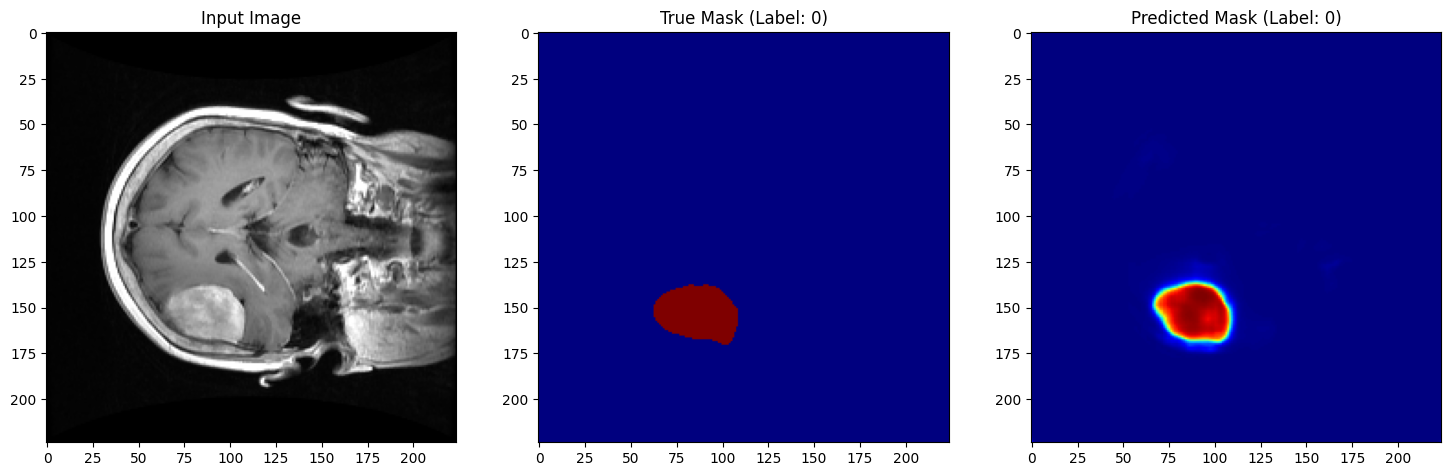

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# انتخاب یک نمونه تصادفی از داده‌های تست
test_idx = np.random.randint(0, len(X_test))
test_img = X_test[test_idx]
test_mask = y_test_mask[test_idx]  # ماسک واقعی سگمنتیشن
test_label = y_test_labels[test_idx]  # برچسب واقعی کلاسیفیکیشن

# پیش‌بینی مدل
pred_outputs = model.predict(test_img[np.newaxis, ...])
pred_mask = pred_outputs[0][0]  # خروجی سگمنتیشن
pred_label = pred_outputs[1][0]  # خروجی کلاسیفیکیشن

# بررسی و اصلاح ابعاد ماسک‌ها
if test_mask.ndim == 3:  # اگر ماسک چند کاناله است (one-hot encoded)
    test_mask = np.argmax(test_mask, axis=-1)
    pred_mask = np.argmax(pred_mask, axis=-1)
else:  # اگر ماسک دودویی است
    test_mask = test_mask.squeeze()
    pred_mask = pred_mask.squeeze()

# پلات نتایج
plt.figure(figsize=(18, 6))

# تصویر ورودی
plt.subplot(1, 3, 1)
plt.imshow(test_img.squeeze(), cmap='gray')
plt.title('Input Image')

# ماسک واقعی
plt.subplot(1, 3, 2)
plt.imshow(test_mask, cmap='jet')
plt.title(f'True Mask (Label: {test_label})')

# ماسک پیش‌بینی شده
plt.subplot(1, 3, 3)
plt.imshow(pred_mask, cmap='jet')
plt.title(f'Predicted Mask (Label: {np.argmax(pred_label)})')

plt.show()